In [1]:
import numpy as np
import pandas as pd
import random, copy, os
random.seed(42)
np.random.seed(42)
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from multiprocessing import Pool
import multiprocessing

In [2]:
%run algorithm_functions.ipynb

In [3]:
%run helper.ipynb

In [4]:
plt.rcParams['font.size'] = 14
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['axes.labelsize'] = 22
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 19
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['figure.titlesize'] = 22
plt.rcParams['lines.linewidth'] = 2.0

In [5]:
%run data_loader.ipynb

Total number of drivers: 32092, total driver types: 750
Total requests: 14486242, types of requests: 8676, total rides: 14486242
Driver Types: 83, Total Drivers: 8386
Request Types: 686, Total requests: 20701


In [6]:
driver_Bu = 10
request_quota = 2
filename_append = 'Bu_{}Q_{}'.format(driver_Bu, request_quota)

## Load drivers and requests

In [7]:
drivers, requests = get_drivers_and_requests(driver_Bu, request_quota)

Chosen driver types: 80
Total number of drivers: 59, Size of set U: 59
Chosen types of requests: 137
Total Sampled Requests: 2148
Initial Number of Requests: 2148.0, size of set V: 137
Final Number of Requests: 931.0 1203, size of set V: 134
Final Number of Drivers: 481, size of set U: 57


In [8]:
# for r in requests:
#     print (r.race)
# for d in drivers:
#     print (d.race, d.quota)

In [9]:
len(drivers), len(requests)

(57, 134)

### Construct a matrix containing the edges, matrix = drivers x requests

In [10]:
probability_matrix = draw_probability_edges(drivers, requests)


In [11]:
print (np.min(probability_matrix[probability_matrix != -1]), 
       np.max(probability_matrix[probability_matrix != -1]), 
       np.mean(probability_matrix[probability_matrix != -1]))
for col in range(probability_matrix.shape[1]):
    if np.all(probability_matrix[:,col] == -1):
        print (requests[col])

0.55 0.8 0.6343220338983051


In [12]:
profit_matrix = np.zeros(probability_matrix.shape)
pfwf_matrix = np.zeros(probability_matrix.shape)
for i,j in zip(*np.where(probability_matrix != -1)):
    if edge_existence_bool(drivers[i], requests[j]) == 0:
        profit_matrix[i,j] = requests[j].distance
    else:
        profit_matrix[i,j] = 0.8 * requests[j].distance
    pfwf_matrix[i,j] = probability_matrix[i,j] * profit_matrix[i,j]
# print(profit_matrix)
# print(pfwf_matrix)

In [13]:
# print(probability_matrix[:,8])
# print(requests[8])
# print(drivers[22])
# print(drivers[20])
# print(drivers[18])
# print(drivers[16])

In [14]:
# for r in requests:
#     print (profit_matrix[:,r.u_id])

In [15]:
(np.count_nonzero(probability_matrix != -1), np.count_nonzero(profit_matrix), 
probability_matrix.shape[0] * probability_matrix.shape[1])

(1534, 1534, 7638)

## In-degrees of drivers and riders

In [16]:
r_vs = []
for r in requests:
    r_vs.append(r.arrival_rate)
min(r_vs), max(r_vs)

in_degree_v = []
for i in range(len(requests)):
    in_degree_v.append(np.count_nonzero(probability_matrix[:,i] != -1))

in_degree_u = []
for i in range(len(drivers)):
    in_degree_u.append(np.count_nonzero(probability_matrix[i,:] != -1))

print ("Drivers' in-degree, average: {}, min: {}, max: {}\nRiders' in-degree, average: {}, min: {}, max: {}"\
       .format(np.mean(in_degree_u), min(in_degree_u), max(in_degree_u), 
               np.mean(in_degree_v), min(in_degree_v), max(in_degree_v)))

Drivers' in-degree, average: 26.912280701754387, min: 4, max: 40
Riders' in-degree, average: 11.447761194029852, min: 4, max: 18


### We have all variables now, use them to solve the LP

In [17]:
from cvxopt.base import matrix as m
from cvxopt import solvers
from cvxopt.modeling import op, dot, variable, max, min

In [18]:
# %run algorithm_functions.ipynb

In [19]:
x_f, x_fair = variable(np.count_nonzero(probability_matrix != -1)), \
    variable(np.count_nonzero(probability_matrix != -1))

In [20]:
# np.set_printoptions(threshold=10)
# print(probability_matrix)
# print(coordinate_to_index(1,2,probability_matrix))

### Profit Objective

In [21]:
profit, c = get_profit_objective(x_f, probability_matrix, profit_matrix)
profit

<linear function of length 1>

### Fairness Objective

In [22]:
def get_fairness_objective_offpeak_v2(x_fair, probability_matrix, drivers):
    # Minimize the negative of the objective function (same as maximizing the objective function)
#     all_requests_fairness = []
    all_drivers_fairness= []
    for i in range(probability_matrix.shape[0]):
        mask = [0] * len(x_fair)
        for j in np.where(probability_matrix[i,:] != -1)[0]:
#             print (len(mask), coordinate_to_index(i, j, probability_matrix), i, j, probability_matrix.shape, len(drivers))
            mask[coordinate_to_index(i, j, probability_matrix)] = \
                -1 * (probability_matrix[i, j]/drivers[i].Bu)
#         print(len(m(mask)), len(x_fair))
        all_drivers_fairness.append(dot(m(mask), x_fair))
    
    cf = []
    for i, j in zip(*np.where(probability_matrix != -1)):
        cf.append(-1 * profit_matrix[i,j] * probability_matrix[i,j]) # multiply by -1 since we want to maximise w_f * x_f * p_f but cvxopt minimizes the objective function by default, since minimizing -obj is same as maximizing obj, we multiply our profit objective by a minus sign
    assert len(cf) == len(x_fair)
    cf = m(cf)
    profit_a = dot(cf, x_fair)
    
    eta = 0.0006
    fairness = max(all_drivers_fairness) + eta * profit_a # solver would minimize this
    
    return fairness

In [23]:
# fairness = get_fairness_objective(x_fair, probability_matrix, requests)
fairness = get_fairness_objective_offpeak_v2(x_fair, probability_matrix, drivers)
fairness

<convex function of length 1>

### Get LP constraints

In [24]:
inequality = get_inequalities_offpeak(x_f, probability_matrix, drivers, requests)
# A,b = get_inequalities_offpeak(x_f, probability_matrix, drivers, requests, True)
# print(A * x_f - b)
# print(A)
# print(type(A*x_f <= b))
# print((b))
# print(inequality)

3393 3393 1534 1534
<class 'cvxopt.modeling._function'>


In [25]:
lp_profit = op(profit, inequality)
lp_profit.solve(solver='glpk')

In [26]:
max(x_f.value), min(x_f.value)

(12.000000000000002, -1.298106921100183e-14)

In [27]:
inequality_fairness = get_inequalities_offpeak(x_fair, probability_matrix, drivers, requests)

3393 3393 1534 1534
<class 'cvxopt.modeling._function'>


In [28]:
lp_fairness = op(fairness, inequality_fairness)
lp_fairness.solve(solver='glpk')

In [29]:
sum(x_f.value)

723.1512237762238

In [30]:
sum(x_fair.value)

717.9366258741258

In [31]:
# Since we multiplied our objective by -1 and then minimized it
optimal_profit = -1 * lp_profit.objective.value()[0]
optimal_fairness = -1 * lp_fairness.objective.value()[0]
print ("When optimizing for fairness, fairness: {}, profit: {}".format(optimal_fairness, 
                                                                      -1 * dot(c, x_fair).value()[0]))
print ("When optimizing for profit, fairness: {}, profit: {}".format(
    -1 * get_fairness_objective_offpeak_v2(x_f, probability_matrix, drivers).value()[0], optimal_profit))

When optimizing for fairness, fairness: 1.0353351756120912, profit: 58.891959353485646
When optimizing for profit, fairness: 1.0353356982120911, profit: 58.89283035348562


In [32]:
lp_solution_sanity_check(x_f, x_fair, probability_matrix, requests)

In [33]:
print (min(x_fair.value), max(x_fair.value))
number_probes = np.zeros(probability_matrix.shape)
for i in range(len(x_fair)):
    number_probes[index_to_coordinate(i, probability_matrix)] += x_fair.value[i]
# print(number_probes)
expected_probes_optimal = np.sum(number_probes, axis=1)
print (expected_probes_optimal)
for i in range(len(drivers)):
    expected_probes_optimal[i] /= drivers[i].Bu
print (expected_probes_optimal)

# for d in drivers:
#     print(d.Bu)
# for r in requests:
#     print(r.arrival_rate)
# A,b = get_inequalities_offpeak(x_fair, probability_matrix, drivers, requests, True)
# print(A*x_fair - b)

0.0 12.0
[24.31818182  5.45454545 12.30769231  6.15384615  9.79020979  8.25174825
  8.13986014 26.53409091 29.63068182  6.15384615 23.75       10.99431818
 10.         10.76923077 22.5        25.90909091 12.32167832 11.25
  5.         12.30769231 25.         10.          7.5        10.18181818
 13.46590909 23.75       12.30769231  6.98863636 26.30681818  7.69230769
  4.61538462 10.          7.69230769  8.46153846 10.90909091 11.78977273
 23.29545455 22.75568182  3.52447552 15.24475524 12.5         3.07692308
 11.94405594  6.15384615 14.54545455 16.05113636 17.27272727  7.69230769
  7.69230769  7.27272727 17.5        10.90909091  3.63636364 10.90909091
  5.45454545 12.30769231 10.        ]
[1.51988636 1.81818182 1.53846154 1.53846154 1.63170163 1.65034965
 1.62797203 1.65838068 1.48153409 1.53846154 1.484375   1.37428977
 1.66666667 1.53846154 1.25       1.43939394 1.54020979 1.40625
 1.25       1.53846154 1.25       1.25       1.25       1.6969697
 1.68323864 1.69642857 1.53846154 1.74

### From this point on x_f is x* and x_fair is y*

In [34]:
drivers_copy = [copy.deepcopy(d) for d in drivers] # to avoid overwriting driver values here

all_requests = []
T = 930
num_loops = 1000
all_r = calculate_T(requests)
p_r = [0] * len(requests)
for r in requests:
    p_r[r.u_id] = r.arrival_rate/all_r
for i in range(num_loops):
    all_requests.append(np.random.choice(requests,T,p_r))
# print(len(all_requests[0]))
# shuffle the requests
# all_requests = []
# for r in requests:
#     all_requests += [r] * int(r.arrival_rate)
# random.shuffle(all_requests)


# This isn't exactly correct since we need to look at "expected fairness"
exact_profit, exact_count, exact_matches = run_algorithm(all_requests[0], drivers_copy, probability_matrix, x_f, x_fair,0,1)
print(exact_count)
# exact_fairness = measure_exact_fairness(all_requests, exact_matches)

# print (exact_profit, optimal_profit, exact_count, len(all_requests))
# print ("Competetive Ratio (Profit): {}, Theoretical lower bound: {}".format(
#     exact_profit/optimal_profit, 0.25 * (1-1/np.e)))
# print ("Competetive Ratio (Fairness): {}, Theoretical lower bound: {}".format(
#     exact_fairness/optimal_fairness, 0.25 * (1-1/np.e)))

388


In [35]:
alphas_0_1, alphas, betas = np.arange(0, 1.01, 0.1), np.arange(0., 1.01, 0.1), np.arange(0.,1.01,0.1)

## Over all params

In [36]:
# matching_results_0_1 = get_matching_results(all_requests, drivers, probability_matrix, 
#                                             x_f, x_fair, alphas_0_1, num_loops)
matching_results = get_matching_results(all_requests, drivers, probability_matrix, 
                                            x_f, x_fair, alphas, num_loops)

In [37]:
# edges_count_results_0_1 = get_edges_count_results(all_requests, matching_results_0_1, requests)
edges_count_results = get_edges_count_results(matching_results, drivers)

In [38]:
len(edges_count_results)
# len(matching_results)

11000

In [39]:
alphas, alphas_0_1

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [40]:
# profit_crs_1, fairness_crs_1 = get_profit_fairness_crs(matching_results_0_1, edges_count_results_0_1, 
#                                                        num_loops, requests, alphas_0_1, optimal_profit, 
#                                                        optimal_fairness)
# print ()
profit_crs, profit_errors, fairness_crs, fairness_errors = get_profit_fairness_crs(matching_results, 
                        edges_count_results, num_loops, requests, alphas, optimal_profit, optimal_fairness)

0.8091707314797577 0.48010677148833414
0.8111155179045961 0.4882476824001926
0.811741148428564 0.49445685173974574
0.811826387225108 0.49859629796611454
0.8115224832267217 0.49919421797659
0.8105725776304585 0.4821305007545589
0.8079830614869984 0.4882476824001926
0.8067968570102638 0.4758523406445663
0.8044636572882506 0.4633765096567605
0.801699625439708 0.4264319520864195
0.799260888809869 0.4203952596729651


In [41]:
# print (np.sum(np.array(edges_count_results), axis=0)/num_loops, np.array([r.arrival_rate for r in requests]))
# expected_fairness_nadap = (np.sum(np.array(edges_count_results), 
#                                   axis=0)/num_loops)/np.array([r.arrival_rate for r in requests])
# expected_fairness_nadap

In [42]:
# expected_probes_optimal

In [43]:
# assert np.min(expected_fairness_nadap) * np.e >= optimal_fairness

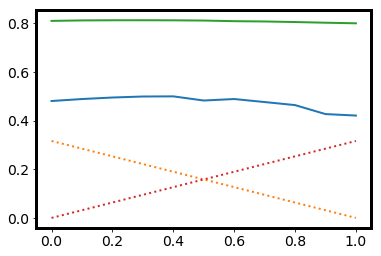

In [44]:
plt.plot(alphas, fairness_crs)
plt.plot(alphas, [x * (1-1/np.e) / 2 for x in 1-alphas], linestyle=':')
plt.plot(alphas, profit_crs)
plt.plot(alphas, [x * (1-1/np.e) / 2 for x in alphas], linestyle=':')

plt.show()

In [67]:
%run helper.ipynb

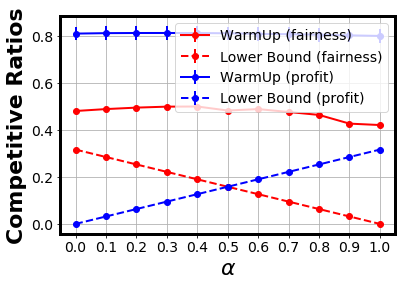

In [68]:
plot_lines([fairness_crs, [x * (1-1/np.e) / 2 for x in 1-alphas], profit_crs, [x * (1-1/np.e) / 2 for x in alphas]], 
           [fairness_errors, [0 for x in alphas], profit_errors, [0 for x in alphas]],
            ["{:.1f}".format(x) for x in alphas], alphas, 
           r'$\beta = 1 - \alpha; B_u = {}; \Delta_v = {}$'.format(driver_Bu, request_quota), 
           r'$\alpha$', 'Competitive Ratios', ['-', '--', '-', '--'], ['red', 'red', 'blue', 'blue'], 
            ['WarmUp (fairness)', 'Lower Bound (fairness)', 'WarmUp (profit)', 'Lower Bound (profit)'], 
            'plots', 'profit_fairness_crs_vs_alpha_{}'.format(filename_append), fmt='pdf', separate_legend=False)

## Greedy_P and Greedy_F algorithms

In [47]:
# uniform_params, greedy_params = [], []
# for i in range(num_loops):
#     drivers_copy = [copy.deepcopy(d) for d in drivers]
#     uniform_params.append([all_requests, drivers_copy, probability_matrix])
# for i in range(num_loops):
#     drivers_copy = [copy.deepcopy(d) for d in drivers]
#     greedy_params.append([all_requests, drivers_copy, probability_matrix, profit_matrix])
greedy_p_params, greedy_f_params = [], []
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_p_params.append([all_requests[i], drivers_copy, probability_matrix, profit_matrix])
for i in range(num_loops):
    drivers_copy = [copy.deepcopy(d) for d in drivers]
    greedy_f_params.append([all_requests[i], drivers_copy, probability_matrix])

In [48]:
def run_greedy_p(all_requests, drivers_copy, probability_matrix, profit_matrix):
    matches, profit = [], 0
#     random.shuffle(all_requests)
    for request in all_requests:
        available_drivers, profits = [], []
        for idx in np.where(probability_matrix[:,request.u_id] != -1)[0]:
            assert drivers_copy[idx].u_id == idx
            if drivers_copy[idx].Bu > 0:
                available_drivers.append(drivers_copy[idx])
                assert probability_matrix[idx, request.u_id] != -1
                profits.append(pfwf_matrix[idx, request.u_id])
        if len(available_drivers) == 0:
            assigned_driver = None
        else:
#             for i in range(1):
            for i in range(request.quota):
                driver_index = np.argmax(profits)
                driver = available_drivers[driver_index]
                p_f = probability_matrix[driver.u_id, request.u_id]
                decision = np.random.choice(np.arange(2), size=1, p=[p_f, 1-p_f])[0]
                if decision == 0: # user accepted the trip
    #                 print ("User {} accepted driver {}!".format(request.u_id, driver.u_id))
                    driver.Bu -= 1
                    assigned_driver = driver
                    break
                else:
                    profits[driver_index] = -1
                    assigned_driver = None
        matches.append(assigned_driver)
        if assigned_driver is not None:
            if (abs(assigned_driver.latitude-request.start_latitude)+abs(assigned_driver.longitude-request.start_longitude)) == 0:
                profit += request.distance
            else:
                profit += 0.8 * request.distance
    return matches, profit

In [49]:
def run_greedy_f(all_requests, drivers_copy, probability_matrix):
    matches, profit = [], 0
#     random.shuffle(all_requests)
    for request in all_requests:
        available_drivers, already_matches = [], []
        for idx in np.where(probability_matrix[:,request.u_id] != -1)[0]:
            assert drivers_copy[idx].u_id == idx
            if drivers_copy[idx].Bu > 0:
                available_drivers.append(drivers_copy[idx])
                assert probability_matrix[idx, request.u_id] != -1
#                 already_matches.append(drivers[idx].Bu - drivers_copy[idx].Bu)
                # change to ratio
                already_matches.append((drivers[idx].Bu - drivers_copy[idx].Bu) / drivers[idx].Bu)
#                 profits.append(profit_matrix[idx, request.u_id])
        if len(available_drivers) == 0:
            assigned_driver = None
        else:
#             for i in range(1):
            for i in range(request.quota):
                driver_index = np.argmin(already_matches)
                driver = available_drivers[driver_index]
                p_f = probability_matrix[driver.u_id, request.u_id]
                decision = np.random.choice(np.arange(2), size=1, p=[p_f, 1-p_f])[0]
                if decision == 0: # user accepted the trip
    #                 print ("User {} accepted driver {}!".format(request.u_id, driver.u_id))
                    driver.Bu -= 1
                    assigned_driver = driver
                    break
                else:
                    already_matches[driver_index] = 2
                    assigned_driver = None
        matches.append(assigned_driver)
        if assigned_driver is not None:
            if (abs(assigned_driver.latitude-request.start_latitude)+abs(assigned_driver.longitude-request.start_longitude)) == 0:
                profit += request.distance
            else:
                profit += 0.8 * request.distance
#     ss = 0
#     for m in matches:
#         if m != None:
#             ss += 1
#     print(ss)
    return matches, profit

In [50]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_p_results = p.starmap(run_greedy_p, greedy_p_params)

In [51]:
with Pool(multiprocessing.cpu_count()) as p:
    greedy_f_results = p.starmap(run_greedy_f, greedy_f_params)

In [52]:
greedy_p_profit = 0
for res in greedy_p_results:
    greedy_p_profit += res[1]
greedy_p_profit /= num_loops
greedy_p_profit_cr = greedy_p_profit/optimal_profit
greedy_p_profit_cr

0.6634116231592293

In [53]:
greedy_p_fairness_measure_params = []
for i in range(num_loops):
    greedy_p_fairness_measure_params.append([greedy_p_results[i][0], drivers])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_p_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_p_fairness_measure_params)

In [54]:
greedy_p_fairness_cr = calculate_fairness_from_array(greedy_p_edges_count_results, 
                                                   num_loops, drivers)/optimal_fairness
greedy_p_fairness_cr

0.8459820748215009

In [55]:
greedy_f_profit = 0
for res in greedy_f_results:
    greedy_f_profit += res[1]
greedy_f_profit /= num_loops
greedy_f_profit_cr = greedy_f_profit/optimal_profit
print(greedy_f_profit_cr)
greedy_f_fairness_measure_params = []
for i in range(num_loops):
    greedy_f_fairness_measure_params.append([greedy_f_results[i][0], drivers])

with Pool(multiprocessing.cpu_count()) as p:
    greedy_f_edges_count_results = p.starmap(measure_fairness_edges_count, greedy_f_fairness_measure_params)
    
greedy_f_fairness_cr = calculate_fairness_from_array(greedy_f_edges_count_results, 
                                                   num_loops, drivers)/optimal_fairness
print(greedy_f_fairness_cr)

0.6220949180605023
0.9633353753390547


In [103]:
def create_dir(dir_path):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

def plot_scatter(all_x_vals, all_y_vals, colors, shapes, annotations, annotation_positions, plot_title, 
                 x_title, y_title, subfolder, filename, labels, separate_legend=False, fmt='png'):
    if isinstance(annotations[0], int) or isinstance(annotations[0], float):
        annotations = list(map(str, annotations))
    fig = plt.figure()
    ax = fig.add_subplot(111)
#     ax.set_title(plot_title)
    ax.set_xlabel(x_title)
    ax.set_ylabel(y_title)
    ax.grid()
    for i, (x_vals, y_vals) in enumerate(zip(all_x_vals, all_y_vals)):
        ax.scatter(x_vals, y_vals, s=64, c=colors[i], marker=shapes[i], label=labels[i])
    flattened_x_vals, flattened_y_vals = [], []
    for x_vals in all_x_vals:
        for x in x_vals:
            flattened_x_vals.append(x)
    for y_vals in all_y_vals:
        for y in y_vals:
            flattened_y_vals.append(y)
    arrowprops = dict(arrowstyle = "->")
    for i, txt in enumerate(annotations):
        if txt != '':
            if i == 0:
                ax.annotate(txt, xytext=(60,-40), textcoords="offset pixels", xy=(flattened_x_vals[i], flattened_y_vals[i]), ha='right', arrowprops=arrowprops) 
            elif i == 4:
                ax.annotate(txt, xytext=(70,-20), textcoords="offset pixels", xy=(flattened_x_vals[i], flattened_y_vals[i]), ha='right', arrowprops=arrowprops) 
            elif i == 10:
                ax.annotate(txt, xytext=(60,-60), textcoords="offset pixels", xy=(flattened_x_vals[i], flattened_y_vals[i]), ha='right', arrowprops=arrowprops)
            else:
                ax.annotate(txt, xytext=(100,0), textcoords="offset pixels", xy=(flattened_x_vals[i], flattened_y_vals[i]), ha='right', arrowprops=arrowprops)
    create_dir('{}'.format(subfolder))
    
    if not separate_legend:
        box = ax.get_position()
#         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax.legend(loc='best')
    else:
        fig_legend = plt.figure(figsize=(3, 3))
        handles, labels = ax.get_legend_handles_labels()
        fig_legend.legend(handles, labels, 'center', ncol=1)
        fig_legend.savefig('{}/{}_legend.{}'.format(subfolder, filename, fmt), 
                           bbox_inches='tight')
    
    fig.savefig('{}/{}.{}'.format(subfolder, filename, fmt), bbox_inches='tight')
    plt.show()
    plt.close()

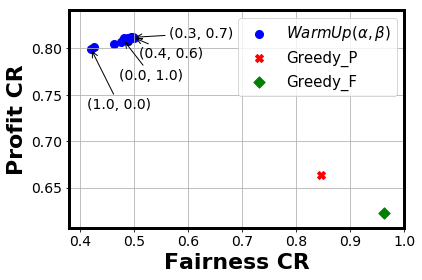

In [104]:
all_x_vals = [fairness_crs , [greedy_p_fairness_cr], [greedy_f_fairness_cr]]
all_y_vals = [profit_crs, [greedy_p_profit_cr], [greedy_f_profit_cr]]
labels = [r'$WarmUp (\alpha, \beta)$', 'Greedy_P', 'Greedy_F']
# annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) for i in range(len(alphas))] + ['', '']
annotations = ['({:.1f}, {:.1f})'.format(alphas[i], 1-alphas[i]) if alphas[i] == 0.0 or alphas[i] == 1.0 or \
               i == np.argmin(fairness_crs) or i == np.argmax(fairness_crs) or i == np.argmin(profit_crs) or \
               i == np.argmax(profit_crs) else '' for i in range(len(alphas))] + ['', '']
annotation_positions = [(fairness_crs[i], 
                         profit_crs[i]) for i in range(len(alphas))]
# print(annotation_positions)
colors = ['blue', 'red', 'green']
shapes = ['o', 'X', 'D']
plot_scatter(all_x_vals, all_y_vals, colors, shapes, annotations, annotation_positions,
             r'$B_u = {}; \Delta_v = {}$'.format(driver_Bu,request_quota), 
             'Fairness CR', 'Profit CR', 'plots', 'fairness_vs_profit_cr_scatter_{}'.format(filename_append),
            labels=labels, fmt='pdf', separate_legend=False)

In [58]:
# calculate_T(requests)

In [59]:
for i in profit_crs:
    print(i)
print(greedy_p_profit_cr)
print(greedy_f_profit_cr)

0.8091707314797577
0.8111155179045961
0.811741148428564
0.811826387225108
0.8115224832267217
0.8105725776304585
0.8079830614869984
0.8067968570102638
0.8044636572882506
0.801699625439708
0.799260888809869
0.6634116231592293
0.6220949180605023


In [60]:
for i in fairness_crs:
    print(i)
print(greedy_p_fairness_cr)
print(greedy_f_fairness_cr)

0.48010677148833414
0.4882476824001926
0.49445685173974574
0.49859629796611454
0.49919421797659
0.4821305007545589
0.4882476824001926
0.4758523406445663
0.4633765096567605
0.4264319520864195
0.4203952596729651
0.8459820748215009
0.9633353753390547
